# Глубинное обучение 1 / Введение в глубинное обучение, ФКН ВШЭ

## Домашнее задание 2: сверточный классификатор.

### Общая информация

Оценка после штрафа после мягкого дедлайна вычисляется по формуле $M_{\text{penalty}} = M_{\text{full}} \cdot 0.85^{t/1440}$, где $M_{\text{full}}$ — полная оценка за работу без учета штрафа, а $t$ — время в минутах, прошедшее после мягкого дедлайна (округление до двух цифр после запятой). Таким образом, спустя первые сутки после мягкого дедлайна вы не можете получить оценку выше 8.5, а если сдать через четыре дня после мягкого дедлайна, то ваш максимум — 5.22 балла.

### Оценивание и штрафы

Максимально допустимая оценка за работу — 10 баллов. Сдавать задание после указанного срока сдачи нельзя.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов. Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке. Также оценка может быть снижена за плохо читаемый код и плохо оформленные графики. Все ответы должны сопровождаться кодом или комментариями о том, как они были получены.

### О задании

В этом задании вам предстоит познакомиться со сверточными сетями и их обучением для классификации изображений с использованием библиотеки PyTorch.


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.model_selection import train_test_split

## 0. Загрузка данных

Работать мы будем с набором данных [CIFAR10](https://www.cs.toronto.edu/~kriz/cifar.html). CIFAR10 представляет собой набор изображений 32х32 пикселя, разделенных на 10 классов.

![title](https://pytorch.org/tutorials/_images/cifar10.png)




Набор данных уже определен в <code>torchvision.datasets</code>, так что возьмем его оттуда. 



In [ ]:
def get_cifar10_data(batch_size, transform_train):
    torch.manual_seed(0)
    np.random.seed(0)

    transform_test = transforms.Compose(
        [transforms.ToTensor(),
         # Переводим цвета пикселей в отрезок [-1, 1]
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
    )
    
    # Загружаем данные
    trainvalset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                               download=True, transform=transform_train)
    testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                           download=True, transform=transform_test)
    
    
    # В датасете определено разбиение только на train и test,
    # так что валидацию дополнительно выделяем из обучающей выборки
    train_idx, valid_idx = train_test_split(np.arange(len(trainvalset)), test_size=0.3, 
                                            shuffle=True, random_state=0)
    trainset = torch.utils.data.Subset(trainvalset, train_idx)
    valset = torch.utils.data.Subset(trainvalset, valid_idx)

    train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                               shuffle=True, num_workers=2)
    val_loader = torch.utils.data.DataLoader(valset, batch_size=batch_size,
                                             shuffle=False, num_workers=2)
    test_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                              shuffle=False, num_workers=2)
    
    return train_loader, val_loader, test_loader
    

In [ ]:
transform = transforms.Compose(
        [transforms.ToTensor(),
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)

train_loader, val_loader, test_loader = get_cifar10_data(batch_size=64, 
                                                         transform_train=transform)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


Посмотрим на изображения:

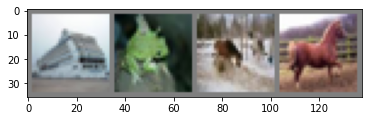

ship frog horse horse


In [ ]:
def imshow(img):
    img = img / 2 + 0.5    
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


dataiter = iter(train_loader)
images, labels = dataiter.next()

imshow(torchvision.utils.make_grid(images[:4]))

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
print(*[classes[labels[i]] for i in range(4)])

## 1. Задание сверточной сети (3 балла)

Теперь нам нужно задать сверточную нейронную сеть, которую мы будем обучать классифицировать изображения.

Используем сеть, основанную на одном блоке архитектуры ResNet.

<img src="https://i.ibb.co/2hg962h/basic-block.png" width="500"/>

__Указания:__

- Все сверточные слои должны иметь 32 выходных канала, а также не должны изменять ширину и высоту изображения.
- Выход блока сократите до размерности 32х4х4, применив average pooling.
- Для получения итоговых логитов, распрямите выход пулинга в вектор из 512 элементов, а затем пропустите его через линейный слой.

**Задание 1.1 (3 балла).**

Определите архитектуру сети соответственно схеме и указаниям выше.

Ключевые слова: <code>Conv2d</code>, <code>BatchNorm2d</code>, <code>AvgPool2d</code>.

In [ ]:
n_classes = 10


class BasicBlockNet(nn.Module):
    def __init__(self):
        super().__init__()

        self.conv = nn.Conv2d(3, 32, 1)

        self.encoder_1 = nn.Sequential( 
            nn.Conv2d(in_channels=3, out_channels=32,
                      kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(in_channels=32, out_channels=32,
                      kernel_size=3, padding=1),
            nn.BatchNorm2d(32)
        )

        self.encoder_2 = nn.Sequential(
            nn.ReLU(),
            nn.AvgPool2d(8),
            nn.Flatten(1),
            nn.Linear(512, n_classes)
        )

    def forward(self, x):

        out = self.encoder_1(x)
        out += self.conv(x)
        out = self.encoder_2(out)

        return out

In [ ]:
net = BasicBlockNet()
net

BasicBlockNet(
  (conv): Conv2d(3, 32, kernel_size=(1, 1), stride=(1, 1))
  (encoder_1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (encoder_2): Sequential(
    (0): ReLU()
    (1): AvgPool2d(kernel_size=8, stride=8, padding=0)
    (2): Flatten(start_dim=1, end_dim=-1)
    (3): Linear(in_features=512, out_features=10, bias=True)
  )
)

Проверим, что выход сети имеет корректную размерность:

In [ ]:
assert net(torch.zeros((10, 3, 32, 32))).shape == (10, 10)

Чтобы проводить вычисления на GPU, в PyTorch необходимо руками перекладывать объекты, с которыми вы хотите проводить вычисления, на графический ускоритель. Это делается следующим образрм:

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [ ]:
net = net.to(device)

Подключение GPU в google.colab:

**Среда выполнения** -> **Сменить среду выполнения** -> **Аппаратный ускоритель** -> **GPU**

## 2. Обучение и тестирование модели (3 балла)

**Задание 2.1 (2 балла).** Переходим к обучению модели. Заполните пропуски в функциях <code>test</code> и <code>train_epoch</code>. В качестве функции потерь будем использовать [кросс-энтропию](https://pytorch.org/docs/stable/generated/torch.nn.functional.cross_entropy.html), а в качестве метрики качества accuracy.

In [ ]:
def test(model, loader):
    loss_log = []
    acc_log = []
    model.eval()
    criterion = nn.CrossEntropyLoss()
    
    for data, target in loader:
        data = data.to(device)
        target = target.to(device)

        with torch.no_grad():
            logits = model(data)
            loss = criterion(logits, target)

        loss_log.append(loss.item() * data.shape[0])
        
        acc = (logits.argmax(dim=1) == target).sum()
        acc_log.append(acc.item() / data.shape[0]) 
        
    return np.mean(loss_log), np.mean(acc_log)

def train_epoch(model, optimizer, train_loader):
    loss_log = []
    acc_log = []
    model.train()
    criterion = nn.CrossEntropyLoss()
    
    for data, target in train_loader:
        data = data.to(device)
        target = target.to(device)
        
        optimizer.zero_grad()
        logits = model(data)

        loss = criterion(logits, target)
        loss.backward()
        optimizer.step()
        
        loss_log.append(loss.item() * data.shape[0])
        
        acc = (logits.argmax(dim=1) == target).sum()
        acc_log.append(acc.item() / data.shape[0]) 

    return loss_log, acc_log

def train(model, optimizer, n_epochs, train_loader, val_loader, scheduler=None):
    train_loss_log, train_acc_log, val_loss_log, val_acc_log = [], [], [], []

    for epoch in range(n_epochs):
        train_loss, train_acc = train_epoch(model, optimizer, train_loader)
        val_loss, val_acc = test(model, val_loader)
        
        train_loss_log.extend(train_loss)
        train_acc_log.extend(train_acc)
        
        val_loss_log.append(val_loss)
        val_acc_log.append(val_acc)

        print(f"Epoch {epoch}")
        print(f" train loss: {np.mean(train_loss)}, train acc: {np.mean(train_acc)}")
        print(f" val loss: {val_loss}, val acc: {val_acc}\n")
        
        if scheduler is not None:
            scheduler.step()

    return train_loss_log, train_acc_log, val_loss_log, val_acc_log

Запустим обучение модели. В качестве оптимизатора будем использовать стохастический градиентный спуск, который является де-факто стандартом в задачах компьютерного зрения (наравне с <code>Adam</code>).

__Замечание:__ Для достижения наилучшего качества в нашем случае потребуется обучать модель несколько сотен эпох. Однако в целях экономии вашего времени и сил, во всех экспериментах мы ограничимся 20 эпохами.

In [ ]:
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
train_loss_log, train_acc_log, val_loss_log, val_acc_log = train(net, optimizer, 20, train_loader, val_loader)

Epoch 0
 train loss: 92.51993818997902, train acc: 0.48628884826325414
 val loss: 80.80930006554786, val acc: 0.5501329787234043

Epoch 1
 train loss: 73.42177600965204, train acc: 0.6005770109689214
 val loss: 71.92152711990032, val acc: 0.609020390070922

Epoch 2
 train loss: 66.07507627145463, train acc: 0.6410289892922434
 val loss: 66.88005109746405, val acc: 0.6365248226950354

Epoch 3
 train loss: 62.79444132077847, train acc: 0.6596369809349699
 val loss: 68.09789402738531, val acc: 0.6287898936170213

Epoch 4
 train loss: 60.24671078600003, train acc: 0.6744131953512668
 val loss: 61.48116400901308, val acc: 0.6654033687943263

Epoch 5
 train loss: 58.5069590852727, train acc: 0.6840518085662053
 val loss: 60.80086920109201, val acc: 0.6767730496453902

Epoch 6
 train loss: 57.033170376660834, train acc: 0.6898749673544006
 val loss: 67.65304657144749, val acc: 0.6441932624113476

Epoch 7
 train loss: 55.874034475364894, train acc: 0.6985056476886915
 val loss: 61.194416151655

Посчитайте точность на тестовой выборке:

In [ ]:
test(net, test_loader)

(55.85172744313623, 0.7019307324840764)

Если вы все сделали правильно, у вас должна была получиться точность $\ge 67\%$.

**Задание 2.2 (1 балл).** Постройте графики зависимости функции потерь и точности классификации от номера шага оптимизатора. На каждом графике расположите данные и для обучающей и для валидационной выборки, итого у вас должно получиться два графика. Обратите внимание, что на обучающей выборке эти данные считаются по каждому батчу, на валидационной же они считаются по всей выборке раз в эпоху.

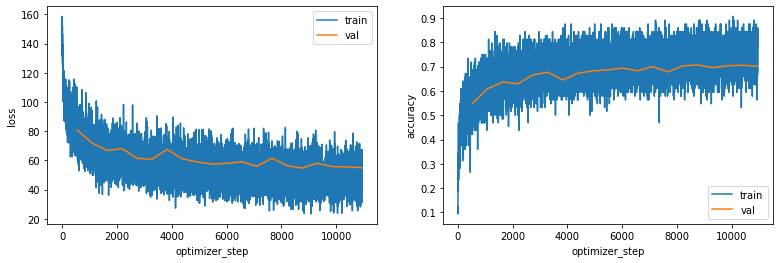

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(13, 4))

steps_num = len(train_acc_log) // 20

axs[0].plot(range(1, len(train_loss_log) + 1), train_loss_log, label='train')
axs[0].plot(range(steps_num, len(train_loss_log) + steps_num, steps_num), val_loss_log, label='val')
axs[0].set_ylabel('loss')

axs[1].plot(range(1, len(train_acc_log) + 1), train_acc_log, label='train')
axs[1].plot(range(steps_num, len(train_acc_log) + steps_num,  steps_num), val_acc_log, label='val')
axs[1].set_ylabel('accuracy')

for ax in axs:
    ax.set_xlabel('optimizer_step')
    ax.legend()

plt.show()

## 3. Расписание длины шага (2 балла)

С курса "Машинное обучение 1" вы уже должны знать, что сходимость стохастического градиентного спуска мы можем теоретически гарантировать только если будем определенным образом со временем уменьшать длину шага. На практике при обучении нейронных сетей такая техника оказывается очень полезной, однако теоретически обоснованными способами уменьшения длины шага фантазия не ограничивается.

Одним из простейших способов является кусочно постоянная функция: на нескольких фиксированных эпохах уменьшаем длину шага в константу раз.

In [ ]:
net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10, 15], gamma=0.1)
tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(net, optimizer, 20, train_loader, val_loader, scheduler)

Epoch 0
 train loss: 94.3567242526485, train acc: 0.4748914533820841
 val loss: 80.28983203400956, val acc: 0.5605274822695034

Epoch 1
 train loss: 73.94814040935454, train acc: 0.5949578871768085
 val loss: 72.4590459945354, val acc: 0.6028368794326242

Epoch 2
 train loss: 68.27068703876336, train acc: 0.629729531209193
 val loss: 69.83788320257308, val acc: 0.6171542553191489

Epoch 3
 train loss: 64.97456726426398, train acc: 0.6470888286758945
 val loss: 64.43716329209347, val acc: 0.6515735815602838

Epoch 4
 train loss: 62.13939888167861, train acc: 0.6626158918777749
 val loss: 63.162252271936296, val acc: 0.6600842198581561

Epoch 5
 train loss: 60.35040810687887, train acc: 0.6739479955601985
 val loss: 60.28159921118554, val acc: 0.6754875886524822

Epoch 6
 train loss: 58.78333925634241, train acc: 0.6801996278401672
 val loss: 60.32351951193302, val acc: 0.6772828014184397

Epoch 7
 train loss: 57.92406859999383, train acc: 0.6844476364586053
 val loss: 58.0502880279054, 

Посчитайте точность на тестовой выборке:

In [ ]:
test(net, test_loader)

(53.8547248111409, 0.7105891719745223)

**Задание 3.0 (0.5 баллов).** Здесь может возникнуть вопрос: а что будет, если мы не будем уменьшать длину шага в процессе обучения, а сразу возьмем констатную, равную значению нашей кусочно-постоянной функции на последних эпохах, то есть $0.001$ в нашем случае. Запустите обучение и проверьте, что в таком случае мы получим худшее качество на тестовой выборке.

In [ ]:
net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(net, optimizer, 20, train_loader, val_loader)

Epoch 0
 train loss: 116.93781012547299, train acc: 0.3604196591799425
 val loss: 102.01180789622855, val acc: 0.44386081560283686

Epoch 1
 train loss: 97.23426038996611, train acc: 0.4704271676677984
 val loss: 92.04313731497906, val acc: 0.48721187943262406

Epoch 2
 train loss: 89.30900091662922, train acc: 0.510393542700444
 val loss: 86.07495352156619, val acc: 0.5171542553191489

Epoch 3
 train loss: 84.46394703287964, train acc: 0.536281503003395
 val loss: 81.7494563163595, val acc: 0.5476507092198583

Epoch 4
 train loss: 80.99607185733383, train acc: 0.5563381431183076
 val loss: 78.51690994830842, val acc: 0.5681959219858157

Epoch 5
 train loss: 78.06049671556657, train acc: 0.5730322864977802
 val loss: 77.98551994486058, val acc: 0.5710992907801418

Epoch 6
 train loss: 75.54152424026015, train acc: 0.5899631104727083
 val loss: 74.5364410278645, val acc: 0.5877659574468085

Epoch 7
 train loss: 73.16550295095774, train acc: 0.6012707299556019
 val loss: 72.1036928136298

In [ ]:
test(net, test_loader)

(60.1662480724845, 0.6706807324840764)

**Задание 3.1 (1.5 балла).** Изучите, какие еще способы уменьшения длины шага представлены в <code>torch.optim.lr_scheduler</code>. Выберите несколько из них, объясните, как они устроены, и обучите модель с ними. Удалось ли добиться улучшения качества на тестовой выборке?

`MultiplicativeLR` --- умножает `lr` на коэффициент, определяемый переданной функцией: $$lr_{\text{epoch}} = lr_{\text{epoch} - 1} * Lambda(\text{epoch})$$

In [ ]:
net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
scheduler = optim.lr_scheduler.MultiplicativeLR(optimizer, lr_lambda=lambda epoch: 0.9 ** (epoch // 3))
tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(net, optimizer, 20, train_loader, val_loader, scheduler)

Epoch 0
 train loss: 94.98871561465359, train acc: 0.47146366544789764
 val loss: 81.6789791715906, val acc: 0.5535904255319148

Epoch 1
 train loss: 75.10776161668069, train acc: 0.5901793875685558
 val loss: 68.86293583727897, val acc: 0.6249113475177306

Epoch 2
 train loss: 67.79876909308285, train acc: 0.6306313658918777
 val loss: 67.97111497838446, val acc: 0.6338874113475178

Epoch 3
 train loss: 63.33068884094629, train acc: 0.6556827827108905
 val loss: 66.32818027252847, val acc: 0.6383421985815604

Epoch 4
 train loss: 60.55348211930047, train acc: 0.6698958605379995
 val loss: 63.34310501179797, val acc: 0.6481826241134753

Epoch 5
 train loss: 58.2191699034989, train acc: 0.6828724862888482
 val loss: 64.18641718803568, val acc: 0.6570257092198583

Epoch 6
 train loss: 56.302554127939004, train acc: 0.6936292112823191
 val loss: 58.906232979957096, val acc: 0.6835992907801418

Epoch 7
 train loss: 54.199274598353526, train acc: 0.7056183076521285
 val loss: 57.11045461208

In [ ]:
test(net, test_loader)

(53.93861789460395, 0.7038216560509554)

`ExponentialLR` --- умножает `lr` на заданный коэффициент `gamma`:
$$lr_{\text{epoch}} = Gamma * lr_{\text{epoch} - 1}$$ 

In [ ]:
net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.98)
tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(net, optimizer, 20, train_loader, val_loader, scheduler)

Epoch 0
 train loss: 94.56194624124977, train acc: 0.47598916166100813
 val loss: 79.96266774522498, val acc: 0.5642730496453902

Epoch 1
 train loss: 74.65082764058924, train acc: 0.5924523374249151
 val loss: 70.2984292943427, val acc: 0.6144281914893617

Epoch 2
 train loss: 67.80353224822329, train acc: 0.6322962914599113
 val loss: 69.77464815505007, val acc: 0.6129210992907801

Epoch 3
 train loss: 64.05436547364788, train acc: 0.6509042831026378
 val loss: 66.47507290129965, val acc: 0.6396054964539007

Epoch 4
 train loss: 61.81592174683454, train acc: 0.6659090167145468
 val loss: 60.27971455188508, val acc: 0.6770833333333333

Epoch 5
 train loss: 59.49049468973219, train acc: 0.6773268150953252
 val loss: 62.06563080726786, val acc: 0.6623005319148936

Epoch 6
 train loss: 57.523713478004694, train acc: 0.6894873008618438
 val loss: 64.46066089386636, val acc: 0.6549867021276595

Epoch 7
 train loss: 56.43772271172002, train acc: 0.6926824889004962
 val loss: 59.095586786878

In [ ]:
test(net, test_loader)

(55.50792172304384, 0.7017316878980892)

`CyclicLR` --- циклично меняет `lr` от наименьшей заданной границы до наибольшей и наоборот, позволяет менять амплитуду изменений 

In [ ]:
net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
scheduler = optim.lr_scheduler.CyclicLR(optimizer, base_lr=0.001, max_lr=0.1, step_size_up=1, mode='triangular2')
tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(net, optimizer, 20, train_loader, val_loader, scheduler)

Epoch 0
 train loss: 119.25121417036875, train acc: 0.3462269848524419
 val loss: 105.16068178542118, val acc: 0.4333776595744681

Epoch 1
 train loss: 91.28259574952901, train acc: 0.49209568425176287
 val loss: 80.85437754773079, val acc: 0.5411347517730497

Epoch 2
 train loss: 71.8405739036295, train acc: 0.6095667928963175
 val loss: 70.77493146125306, val acc: 0.616267730496454

Epoch 3
 train loss: 70.62761614309586, train acc: 0.6145860537999478
 val loss: 67.49449946220885, val acc: 0.6317597517730498

Epoch 4
 train loss: 61.66528961122363, train acc: 0.6685573909636982
 val loss: 62.42135372364775, val acc: 0.6614361702127659

Epoch 5
 train loss: 63.25314879548179, train acc: 0.6566784734917733
 val loss: 66.07835180404338, val acc: 0.6363475177304966

Epoch 6
 train loss: 58.233583585435774, train acc: 0.6857901867328283
 val loss: 59.38326741482349, val acc: 0.6797429078014183

Epoch 7
 train loss: 58.97933060159631, train acc: 0.6814238378166623
 val loss: 60.91914359762

In [ ]:
test(net, test_loader)

(56.57622017830041, 0.6948646496815286)

**Итог:** все рассмотренные варианты оказались лучше статичного шага

## 4. Аугментации данных (2 балла)

Еще одной стандартной техникой, применяющейся в глубинном обучении, а особенно часто в компьютерном зрении, являются аугментации данных. Суть аугментаций состоит в том, что мы можем некоторым синтетическим образом видоизменять объекты обучающей выборки, тем самым расширяя ее, а также делая итоговую модель более устойчивой к таким изменениям.

Простейшая аугментация, которую можно применить к картинкам — разворот картинки по горизонтальной оси. То есть при обучении модели с вероятностью $0.5$ мы будем разворачивать картинку из обучающей выборки.

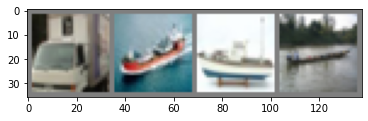

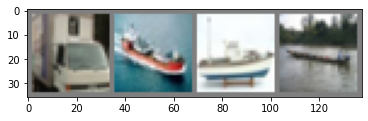

In [ ]:
dataiter = iter(train_loader)
images, labels = dataiter.next()

imshow(torchvision.utils.make_grid(images[:4]))

imshow(torchvision.utils.make_grid(transforms.functional.hflip(images[:4])))

Наиболее удобным способом работы с аугментациями в PyTorch является их задание в списке <code>transforms</code>, который затем передается в загрузчик данных. Обучим нашу сеть, применяя горизонтальные повороты:

In [ ]:
transform = transforms.Compose(
        [transforms.RandomHorizontalFlip(),
         transforms.ToTensor(),
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)

train_loader, val_loader, test_loader = get_cifar10_data(batch_size=64, transform_train=transform)

net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10, 15], gamma=0.1)
tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(net, optimizer, 20, train_loader, val_loader, scheduler)

Files already downloaded and verified
Files already downloaded and verified
Epoch 0
 train loss: 95.60588914602722, train acc: 0.4685622878036041
 val loss: 82.68743131515828, val acc: 0.5338652482269504

Epoch 1
 train loss: 75.76142015579195, train acc: 0.5848214285714286
 val loss: 70.67258849042527, val acc: 0.613563829787234

Epoch 2
 train loss: 67.98944525396148, train acc: 0.628958278924001
 val loss: 68.70630889243267, val acc: 0.6301196808510638

Epoch 3
 train loss: 64.49561073400857, train acc: 0.6528222120658135
 val loss: 66.81824891922322, val acc: 0.6442597517730497

Epoch 4
 train loss: 62.13585360350949, train acc: 0.6640400561504309
 val loss: 64.61304280301358, val acc: 0.6470744680851064

Epoch 5
 train loss: 59.93064283060635, train acc: 0.6764617067119352
 val loss: 62.20262024656255, val acc: 0.6591755319148936

Epoch 6
 train loss: 58.907283772498204, train acc: 0.6829173739879864
 val loss: 60.158716985012624, val acc: 0.6747783687943263

Epoch 7
 train loss: 

Посчитайте точность на тестовой выборке:

In [ ]:
test(net, test_loader)

(51.65582768628552, 0.721437101910828)

**Задание 4.1 (2 балла).** Изучите, какие еще способы аугментаций изображений представлены в <code>torchvision.transforms</code>. Выберите несколько из них, объясните, как они устроены, и обучите модель с ними (по отдельности и вместе). Удалось ли добиться улучшения качества на тестовой выборке?

`ColorJiter` --- рандомно меняет яркость, контраст, насыщенность и оттенок картнки

`RandomRotation` --- поворачивает картинку на рандомный угол в заданных пределах

`GaussianBlur` --- размывает картинку

In [ ]:
transform = transforms.Compose(
        [transforms.ColorJitter(),
         transforms.ToTensor(),
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)

train_loader, val_loader, test_loader = get_cifar10_data(batch_size=64, transform_train=transform)

net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10, 15], gamma=0.1)
tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(net, optimizer, 20, train_loader, val_loader, scheduler)

Files already downloaded and verified
Files already downloaded and verified
Epoch 0
 train loss: 96.24764731161338, train acc: 0.46245348002089315
 val loss: 83.50946217394889, val acc: 0.5280806737588652

Epoch 1
 train loss: 75.9768377265721, train acc: 0.5817445808305041
 val loss: 71.84604775043245, val acc: 0.6082225177304965

Epoch 2
 train loss: 68.08992859737529, train acc: 0.6301539240010446
 val loss: 69.26939742514428, val acc: 0.6212544326241135

Epoch 3
 train loss: 64.31495429218579, train acc: 0.651357240793941
 val loss: 67.05864683110663, val acc: 0.6395390070921987

Epoch 4
 train loss: 61.93435795520734, train acc: 0.663782972055367
 val loss: 65.54673949302511, val acc: 0.642575354609929

Epoch 5
 train loss: 59.7420016468334, train acc: 0.6745968268477409
 val loss: 65.21467689757651, val acc: 0.6434618794326242

Epoch 6
 train loss: 58.30271247187306, train acc: 0.6852719378427788
 val loss: 62.068864883260524, val acc: 0.661081560283688

Epoch 7
 train loss: 57.4

In [ ]:
test(net, test_loader)

(52.802029561085305, 0.7175557324840764)

In [ ]:
transform = transforms.Compose(
        [transforms.RandomRotation(degrees=60),
         transforms.ToTensor(),
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)

train_loader, val_loader, test_loader = get_cifar10_data(batch_size=64, transform_train=transform)

net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10, 15], gamma=0.1)
tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(net, optimizer, 20, train_loader, val_loader, scheduler)

Files already downloaded and verified
Files already downloaded and verified
Epoch 0
 train loss: 110.02207279205322, train acc: 0.3839897819273962
 val loss: 101.81485959316822, val acc: 0.42912234042553193

Epoch 1
 train loss: 98.20493494309281, train acc: 0.4506357730477932
 val loss: 97.99191433115209, val acc: 0.4529255319148936

Epoch 2
 train loss: 92.72169619635211, train acc: 0.4859787150692086
 val loss: 91.2061312695767, val acc: 0.491334219858156

Epoch 3
 train loss: 89.6842579571377, train acc: 0.502207658657613
 val loss: 90.77162108319871, val acc: 0.49847074468085106

Epoch 4
 train loss: 87.11916702451828, train acc: 0.5191303212326979
 val loss: 86.45846614026009, val acc: 0.5196365248226951

Epoch 5
 train loss: 84.76543568082876, train acc: 0.5300339514233482
 val loss: 84.88969674211867, val acc: 0.5311835106382978

Epoch 6
 train loss: 83.11943320426035, train acc: 0.541549686602246
 val loss: 82.42416559178778, val acc: 0.5417331560283688

Epoch 7
 train loss: 8

In [ ]:
test(net, test_loader)

(65.8686141299594, 0.6391321656050956)

In [ ]:
transform = transforms.Compose(
        [transforms.GaussianBlur(kernel_size=(5, 9)),
         transforms.ToTensor(),
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)

train_loader, val_loader, test_loader = get_cifar10_data(batch_size=64, transform_train=transform)

net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10, 15], gamma=0.1)
tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(net, optimizer, 20, train_loader, val_loader, scheduler)

Files already downloaded and verified
Files already downloaded and verified
Epoch 0
 train loss: 103.9139998085538, train acc: 0.4174107142857143
 val loss: 94.84793359878215, val acc: 0.47012411347517724

Epoch 1
 train loss: 88.3964236867929, train acc: 0.5100140376077305
 val loss: 81.73158489389623, val acc: 0.549357269503546

Epoch 2
 train loss: 82.32485394068131, train acc: 0.5439124118568817
 val loss: 78.32370707735102, val acc: 0.5642952127659574

Epoch 3
 train loss: 78.33696816564697, train acc: 0.5674498890049621
 val loss: 75.91153641152889, val acc: 0.5820921985815604

Epoch 4
 train loss: 75.81283335537536, train acc: 0.5842011621833377
 val loss: 74.46188512355724, val acc: 0.5918882978723404

Epoch 5
 train loss: 73.8290246304472, train acc: 0.5926930987202925
 val loss: 76.90022831368954, val acc: 0.5808732269503545

Epoch 6
 train loss: 72.42495415459167, train acc: 0.6021317576390702
 val loss: 72.20070847856238, val acc: 0.597872340425532

Epoch 7
 train loss: 72.

In [ ]:
test(net, test_loader)

(62.38205199029036, 0.6653065286624203)

## Бонус. Логирование в wandb (2 балла)

На практике специалиста по глубинному обучению часто встречаются ситуации, когда нейросеть учится на каком-то удаленном сервере. И обычно вам хочется отслеживать прогресс обучения, особенно когда время обучения модели исчисляется днями или неделями. Для таких целей существует несколько инструментов. Вероятно, самый популярный из них — [wandb](https://wandb.ai/site).

Ваша задача состоит в том, чтобы разобраться как им пользоваться, и повторить задания 2.1 и 2.2 с его использованием. Обучение вы можете запускать в этом же ноутбуке, но теперь вам необходимо через wandb логировать значения функции потерь и точности на обучающей выборке и на валидационной. Результатом работы должны быть ваш код и публичная ссылка на страничку с графиками, идентичными графикам в задании 2.2.

In [ ]:
!pip install wandb -qU

     |████████████████████████████████| 1.9 MB 27.6 MB/s 
     |████████████████████████████████| 182 kB 69.1 MB/s 
     |████████████████████████████████| 166 kB 57.2 MB/s 
     |████████████████████████████████| 63 kB 2.0 MB/s 
     |████████████████████████████████| 166 kB 74.0 MB/s 
     |████████████████████████████████| 162 kB 67.7 MB/s 
     |████████████████████████████████| 162 kB 71.4 MB/s 
     |████████████████████████████████| 158 kB 77.1 MB/s 
     |████████████████████████████████| 157 kB 56.6 MB/s 
     |████████████████████████████████| 157 kB 59.2 MB/s 
     |████████████████████████████████| 157 kB 68.4 MB/s 
     |████████████████████████████████| 157 kB 77.4 MB/s 
     |████████████████████████████████| 157 kB 71.9 MB/s 
     |████████████████████████████████| 157 kB 76.1 MB/s 
     |████████████████████████████████| 157 kB 69.8 MB/s 
     |████████████████████████████████| 156 kB 70.3 MB/s 


In [ ]:
!wandb login --relogin

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [ ]:
import wandb


wandb.init(project='cnn-project')

ERROR:wandb.jupyter:Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: kvdmitrieva. Use `wandb login --relogin` to force relogin


In [ ]:
def train_with_log(model, optimizer, n_epochs, train_loader, val_loader, scheduler=None):

    for epoch in range(n_epochs):
        criterion = nn.CrossEntropyLoss()
        first = True
        model.train()
        for data, target in train_loader:
            if not first:
                wandb.log({'train_loss': loss.item() * data.shape[0], 
                           'train_accuracy': acc.item() / data.shape[0]})
            else:
              first = False

            data = data.to(device)
            target = target.to(device)
            
            optimizer.zero_grad()
            logits = model(data)

            loss = criterion(logits, target)
            loss.backward()
            optimizer.step()

            acc = (logits.argmax(dim=1) == target).sum()
            

        val_loss, val_acc = test(model, val_loader)

        wandb.log({'train_loss': loss.item() * data.shape[0],
                   'train_accuracy': acc.item() / data.shape[0],
                   'val_loss': val_loss,
                   'val_accuracy': val_acc})

        print(f"Epoch {epoch}")
        print(f" val loss: {val_loss}, val acc: {val_acc}\n")
        
        if scheduler is not None:
            scheduler.step()

In [ ]:
transform = transforms.Compose(
        [transforms.ToTensor(),
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)

train_loader, val_loader, test_loader = get_cifar10_data(batch_size=64, 
                                                         transform_train=transform)

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
train_with_log(net, optimizer, 20, train_loader, val_loader)

Epoch 0
 val loss: 79.98092727255315, val acc: 0.5496010638297872

Epoch 1
 val loss: 72.65145661374356, val acc: 0.608843085106383

Epoch 2
 val loss: 69.89266678627502, val acc: 0.6265292553191489

Epoch 3
 val loss: 64.9025123028045, val acc: 0.6519725177304966

Epoch 4
 val loss: 67.8921953891186, val acc: 0.6310283687943263

Epoch 5
 val loss: 65.3949342768243, val acc: 0.6422207446808511

Epoch 6
 val loss: 59.98304380457452, val acc: 0.674002659574468

Epoch 7
 val loss: 60.070538930690034, val acc: 0.6794991134751774

Epoch 8
 val loss: 61.4352227738563, val acc: 0.6728945035460993

Epoch 9
 val loss: 57.336844391518454, val acc: 0.6926196808510638

Epoch 10
 val loss: 57.793238124441594, val acc: 0.6888741134751774

Epoch 11
 val loss: 59.409146162804134, val acc: 0.6821808510638298

Epoch 12
 val loss: 56.35527218351973, val acc: 0.6953457446808511

Epoch 13
 val loss: 58.71529224679825, val acc: 0.686968085106383

Epoch 14
 val loss: 57.19097531501283, val acc: 0.69665336879

[графики](https://wandb.ai/kvdmitrieva/cnn-project?workspace=user-kvdmitrieva)